# 세팅
---

## 기온 예측 문제
지금까지 다룬 시퀀스 데이터는 IMDB 데이터셋이나 로이터 데이터셋과 같은 텍스트 데이터입니다. 시퀀스 데이터는 이런 언어 처리 분야뿐만 아니라 훨씬 많은 문제에서 등장합니다. 이 절에 있는 모든 예제는 날씨 시계열 데이터셋을 사용합니다. 이 데이터는 독일 예나 시에 있는 막스 플랑크 생물지구화학 연구소( http://www.bgc-jena.mpg.de/wetter/ )의 지상 관측소에서 수집한 것입니다.

이 데이터셋에는 수년간에 걸쳐 (기온, 기압, 습도, 풍향 등과 같은) 14개의 관측치가 10분마다 기록되어 있습니다. 원본 데이터는 2003년부터 기록되어 있지만 이 예제에서는 2009~2016년 사이의 데이터만 사용합니다. 이 데이터셋은 시계열 수치 데이터를 다루는 법을 익히는 데 안성맞춤입니다. 최근 데이터(몇 일치 데이터 포인트)를 입력으로 사용해 모델을 만들고 24시간 이후의 기온을 예측하겠습니다.

In [13]:
import set_matplotlib_hangul
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Sequential, callbacks, optimizers, losses, activations
from Myfunc import show_lcurve

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
data_path = "D:/Dataset/dataset/jena_climate/jena_climate_2009_2016.csv"
f = open(data_path)
data = f.read()
f.close()
lines = data.split("\n")
print("데이터 개수 :",len(lines))
header = lines[0]
lines = lines[1: ]
print("헤더 :",header)
print("데이터 :", lines[0])

데이터 개수 : 420552
헤더 : "Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"
데이터 : 01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30


In [4]:
lines_arr = []
for idx, line in enumerate(lines):
    values = []
    for x in line.split(",")[1:]: # 10분단위로 측정된 시간은 제외하고 가져옵니다.
        value = float(x)
        values.append(value)
    lines_arr.append(values)
lines_arr = np.array(lines_arr) # 420,551개 데이터 전체를 넘파이 배열로 바꿉니다
print(lines_arr.shape)

(420551, 14)


420551 의 timestep 이 있고, 1번의 timestep에 14개의 데이터가 들어옴

예를 들어 다음은 시간에 따른 기온(섭씨) 그래프입니다:

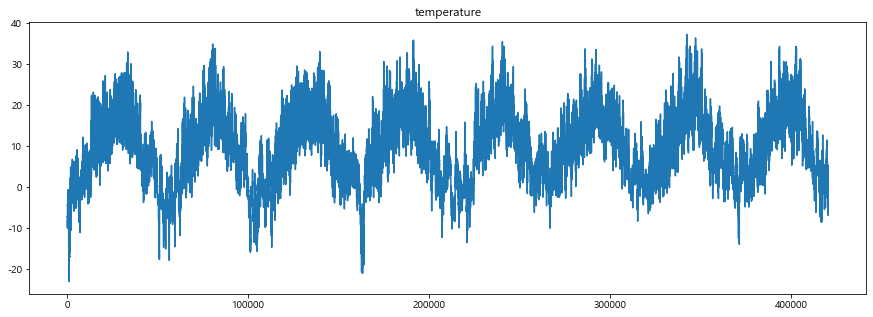

In [5]:
tempC = lines_arr[ : ,1] # 모든시간에 대한 기온
plt.figure(figsize=(15,5))
plt.plot(tempC)
plt.title("temperature")
plt.show()

이 그래프에서 온도에 주기성이 있다는 것을 잘 볼 수 있습니다.

다음은 기간을 좁혀서 처음 10일간의 온도 데이터를 나타낸 그래프입니다. 10분마다 데이터가 기록되므로 하루에 총 144개의 데이터 포인트가 있습니다:

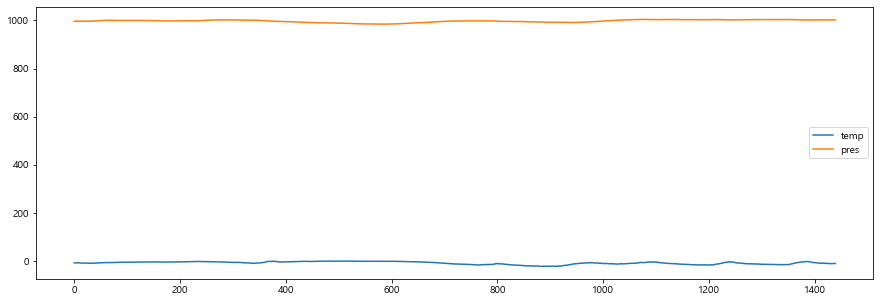

In [6]:
tempC = lines_arr[:1440, 1]# 1440 개의 데이터를 확인
pressure = lines_arr[:1440, 0]# 1440 개의 데이터를 확인
plt.figure(figsize=(15,5))
plt.plot(tempC, label="temp")
plt.plot(pressure, label="pres")
plt.legend()
plt.show()

이 그래프에서 일별 주기성을 볼 수 있습니다. 특히 마지막 4일간을 보면 확실합니다. 이 데이터는 아주 추운 겨울 중 10일입니다.

지난 몇 달간의 데이터를 사용해 다음 달의 평균 온도를 예측하는 문제는 쉬운 편입니다. 연간 데이터 주기성은 안정적이기 때문입니다. 하지만 하루 하루 데이터를 살펴보면 온도 변화는 매우 불안정합니다. 일자별 수준의 시계열 데이터를 예측할 수 있을까요? 직접 확인해 보겠습니다.

## Preparing the data

이 문제의 정확한 정의는 다음과 같습니다. `lookback` 타임스텝(하나의 타임스텝은 10분입니다)만큼 이전으로 돌아가서 매 `steps` 타임스텝마다 샘플링합니다. 이 데이터를 바탕으로 `delay` 타임스텝 이후의 온도를 예측할 수 있을까요? 사용할 변수는 다음과 같습니다.

* `lookback = 1440` : 10일 전 데이터로 돌아갑니다.
* `steps = 6` : 한 시간마다 데이터 포인트 하나를 샘플링합니다.
* `delay = 144` : 24시간이 지난 데이터가 타깃이 됩니다.

시작하기 전에 두 가지 작업을 처리해야 합니다:

* 신경망에 주입할 수 있는 형태로 데이터를 전처리합니다. 데이터가 이미 수치형이므로 추가적인 벡터화가 필요하지 않습니다. 하지만 데이터에 있는 각 시계열 특성의 범위가 서로 다릅니다(예를 들어 온도는 일반적으로 -20도에서 +30도 사이이고, 밀리바(mb)로 측정된 기압은 1,000 근처의 값입니다). 각 시계열 특성을 개별적으로 정규화하여 비슷한 범위를 가진 작은 값으로 바꾸겠습니다.
* float_data 배열을 받아 과거 데이터의 배치와 미래 타깃 온도를 추출하는 파이썬 제너레이터를 만듭니다. 이 데이터셋에 있는 샘플은 중복이 많습니다(샘플 `N`과 샘플 `N + 1`은 대부분 타임스텝이 비슷합니다). 모든 샘플을 각기 메모리에 적재하는 것은 낭비가 심하므로 대신에 원본 데이터를 사용해 그때 그때 배치를 만들겠습니다.

각 시계열 특성에 대해 평균을 빼고 표준 편차로 나누어 전처리합니다. 처음 200,000개 타임스텝을 훈련 데이터로 사용할 것이므로 전체 데이터에서 200,000개만 사용하여 평균과 표준 편차를 계산합니다:

In [7]:
# 정규화
mean =  lines_arr.mean(axis=0)
std = lines_arr.std(axis=0)
float_data = (lines_arr - mean) / std

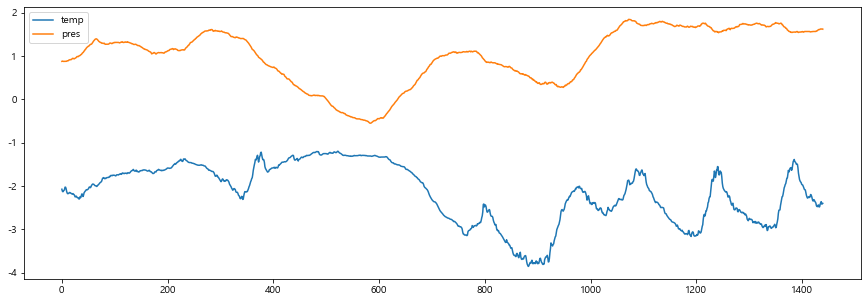

In [8]:
tempC = float_data[:1440, 1]# 1440 개의 데이터를 확인
pressure = float_data[:1440, 0]# 1440 개의 데이터를 확인
plt.figure(figsize=(15,5))
plt.plot(tempC, label="temp")
plt.plot(pressure, label="pres")
plt.legend()
plt.show()

다음은 여기서 사용할 제너레이터입니다. 이 제너레이터 함수는 `(samples, targets)` 튜플을 반복적으로 반환합니다. `samples`는 입력 데이터로 사용할 배치이고 `targets`은 이에 대응되는 타깃 온도의 배열입니다. 이 제너레이터 함수는 다음과 같은 매개변수가 있습니다:

* `data` : 코드 6-32에서 정규화한 부동 소수 데이터로 이루어진 원본 배열
* `lookback` : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
* `delay` : 타깃으로 사용할 미래의 타임스텝
* `min_index`와 `max_index` : 추출할 타임스텝의 범위를 지정하기 위한 `data` 배열의 인덱스. 검증 데이터와 테스트 데이터를 분리하는 데 사용합니다.
* `shuffle` : 샘플을 섞을지 시간 순서대로 추출할지 결정합니다.
* `batch_size` : 배치의 샘플 수
* `step` : 데이터를 샘플링할 타임스텝 간격. 한 시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정하겠습니다.

In [9]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6, rev=False):
    if max_index is None:
        max_index = len(data) - delay - 1
        
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        if rev:
            yield samples[:, ::-1, :], targets
        else:
            yield samples, targets

이제 generator 함수를 사용해 훈련용, 검증용, 테스트용으로 세 개의 제너레이터를 만들어 보죠. 각 제너레이터는 원본 데이터에서 다른 시간대를 사용합니다. 훈련 제너레이터는 처음 200,000개 타임스텝을 사용하고 검증 제너레이터는 그 다음 100,000개를 사용하고 테스트 제너레이터는 나머지를 사용합니다.

In [10]:
lookback = 1440
step = 6
delay = 144
batch_size = 512

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

(512, 240, 14) (512,)


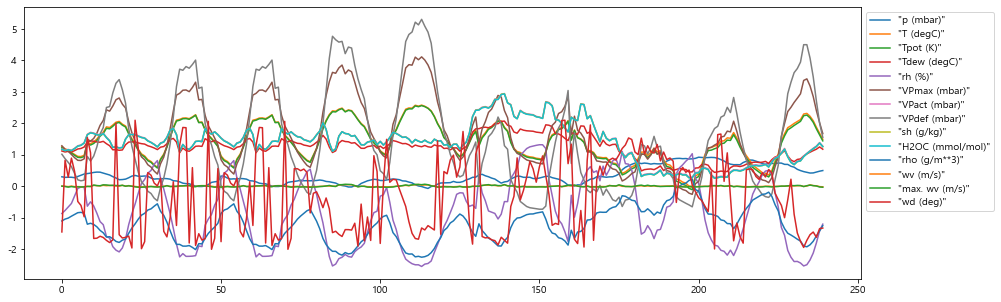

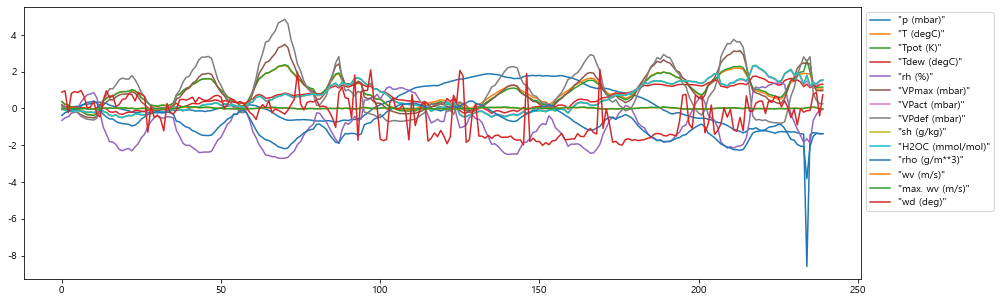

In [11]:
for samples, targets in train_gen:
    print(samples.shape, targets.shape )
    for i in range(2):
        plt.figure(figsize=(15,5))
        plt.plot(samples[i])
        plt.legend(header.split(",")[1:], bbox_to_anchor=(1,1))
        plt.show()
    break

* 이렇게 만들어둔 각각의 데이터는 24시간 후의 기온을 맞추게 된다

## 상식 수준의 기준점

블랙 박스 같은 딥러닝 모델을 사용해 온도 예측 문제를 풀기 전에 간단한 상식 수준의 해법을 시도해 보겠습니다. 이는 정상 여부 확인을 위한 용도이고 고수준 머신 러닝 모델이라면 뛰어 넘어야 할 기준점을 만듭니다. 이런 상식 수준의 해법은 알려진 해결책이 없는 새로운 문제를 다루어야 할 때 유용합니다. 일부 클래스가 월등히 많아 불균형한 분류 문제가 고전적인 예입니다. 데이터셋에 클래스 A의 샘플이 90%, 클래스 B의 샘플이 10%가 있다면, 이 분류 문제에 대한 상식 수준의 접근법은 새로운 샘플을 항상 클래스 'A'라고 예측하는 것입니다. 이 분류기는 전반적으로 90%의 정확도를 낼 것입니다. 머신 러닝 기반의 모델이라면 90% 이상을 달성해야 유용하다고 볼 수 있습니다. 이따금 이런 기본적인 기준점을 넘어서기가 아주 어려운 경우가 있습니다.

이 경우 온도 시계열 데이터는 연속성이 있고 일자별로 주기성을 가진다고 가정할 수 있습니다(오늘 온도는 내일 온도와 비슷할 가능성이 높습니다). 그렇기 때문에 상식 수준의 해결책은 지금으로부터 24시간 후의 온도는 지금과 동일하다고 예측하는 것입니다. 이 방법을 평균 절댓값 오차(MAE)로 평가해 보겠습니다:

```python
np.mean(np.abs(preds - targets))
```

다음은 평가를 위한 반복 루프입니다:

In [12]:
def evaluate_method():
    maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        maes.append(mae)
    return np.mean(maes)
result = evaluate_method()
print("N-mae :", result)
print("mae :", result*std[1])

N-mae : 0.30469286825185327
mae : 2.566536254882813


* MAE 는 0.30 이다. 여기에 표준편차를 곱해주면 2.56 이 된다.
* 즉 평균적으로 24시간 이후의 온도는 2.56도가 차이난다

## 기본적인 머신 러닝

In [76]:
timestep = 240
features = 14

model = Sequential()
model.add(layers.Input(shape=(timestep, features)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(1))

lr = callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3)
optimizer = optimizers.RMSprop(learning_rate=0.001)

model.compile(optimizer=optimizer, loss="mae")
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=20,
                    steps_per_epoch=125,
                    validation_steps=val_steps,
                    callbacks=[lr])

Epoch 1/20
125/125 [==============================] - 8s 59ms/step - loss: 3.0652 - val_loss: 1.7662
Epoch 2/20
125/125 [==============================] - 7s 57ms/step - loss: 1.4162 - val_loss: 0.9812
Epoch 3/20
125/125 [==============================] - 7s 57ms/step - loss: 0.8476 - val_loss: 0.7441
Epoch 4/20
125/125 [==============================] - 7s 59ms/step - loss: 0.5398 - val_loss: 0.6476
Epoch 5/20
125/125 [==============================] - 7s 57ms/step - loss: 0.4033 - val_loss: 0.3126
Epoch 6/20
125/125 [==============================] - 7s 58ms/step - loss: 0.3444 - val_loss: 0.3171
Epoch 7/20
125/125 [==============================] - 7s 58ms/step - loss: 0.3359 - val_loss: 0.3221
Epoch 8/20
125/125 [==============================] - 7s 58ms/step - loss: 0.3146 - val_loss: 0.3422
Epoch 9/20
125/125 [==============================] - 7s 58ms/step - loss: 0.2780 - val_loss: 0.3073
Epoch 10/20
125/125 [==============================] - 7s 58ms/step - loss: 0.2649 - val_lo

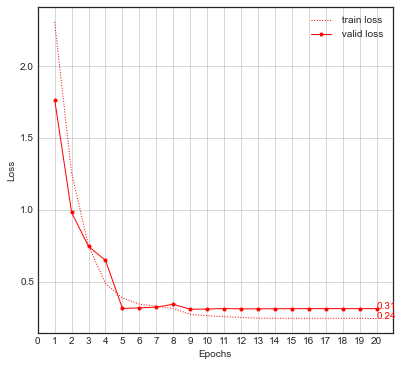

In [78]:
show_lcurve([history], [""], size=[14,6])

* 0.3 보다 낮아지지 않으므로 유의미한 모델이 아니다

## 기본 순환 신경망

In [17]:
model = Sequential()
model.add(layers.Input(shape=(timestep, features)))
model.add(layers.SimpleRNN(32))
model.add(layers.Dense(1))
          
opt = optimizers.RMSprop(learning_rate=0.001)
          
model.compile(optimizer=opt, loss="mae")
          
history_rnn = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=20,
                    steps_per_epoch=125,
                    validation_steps=val_steps,
                    callbacks=[lr])

Epoch 1/20
125/125 [==============================] - 25s 187ms/step - loss: 0.3781 - val_loss: 0.3005
Epoch 2/20
125/125 [==============================] - 21s 169ms/step - loss: 0.3140 - val_loss: 0.2934
Epoch 3/20
125/125 [==============================] - 20s 161ms/step - loss: 0.3110 - val_loss: 0.2944
Epoch 4/20
125/125 [==============================] - 26s 206ms/step - loss: 0.3081 - val_loss: 0.2927
Epoch 5/20
125/125 [==============================] - 24s 189ms/step - loss: 0.3082 - val_loss: 0.2870
Epoch 6/20
125/125 [==============================] - 22s 178ms/step - loss: 0.3017 - val_loss: 0.2910
Epoch 7/20
125/125 [==============================] - 22s 180ms/step - loss: 0.2986 - val_loss: 0.2873
Epoch 8/20
125/125 [==============================] - 24s 194ms/step - loss: 0.3007 - val_loss: 0.2877
Epoch 9/20
125/125 [==============================] - 23s 185ms/step - loss: 0.3040 - val_loss: 0.2892
Epoch 10/20
125/125 [==============================] - 23s 187ms/step - l

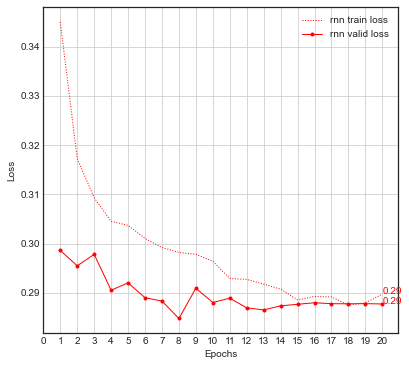

In [91]:
show_lcurve([history_rnn], ["rnn"], size=[14,6])

## LSTM 순환 신경망

In [90]:
model = Sequential()
model.add(layers.Input(shape=(timestep, features)))
model.add(layers.LSTM(32))
model.add(layers.Dense(1))
          
opt = optimizers.RMSprop(learning_rate=0.001)
          
model.compile(optimizer=opt, loss="mae")
          
history_lstm = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=20,
                    steps_per_epoch=125,
                    validation_steps=val_steps,
                    callbacks=[lr])

Epoch 1/20
125/125 [==============================] - 10s 65ms/step - loss: 0.3990 - val_loss: 0.2959
Epoch 2/20
125/125 [==============================] - 8s 62ms/step - loss: 0.3033 - val_loss: 0.2893
Epoch 3/20
125/125 [==============================] - 8s 61ms/step - loss: 0.2972 - val_loss: 0.2902
Epoch 4/20
125/125 [==============================] - 8s 60ms/step - loss: 0.2894 - val_loss: 0.2845
Epoch 5/20
125/125 [==============================] - 7s 60ms/step - loss: 0.2830 - val_loss: 0.2867
Epoch 6/20
125/125 [==============================] - 7s 60ms/step - loss: 0.2805 - val_loss: 0.2967
Epoch 7/20
125/125 [==============================] - 7s 60ms/step - loss: 0.2786 - val_loss: 0.2920
Epoch 8/20
125/125 [==============================] - 7s 60ms/step - loss: 0.2704 - val_loss: 0.2921
Epoch 9/20
125/125 [==============================] - 8s 61ms/step - loss: 0.2679 - val_loss: 0.2924
Epoch 10/20
125/125 [==============================] - 8s 60ms/step - loss: 0.2638 - val_l

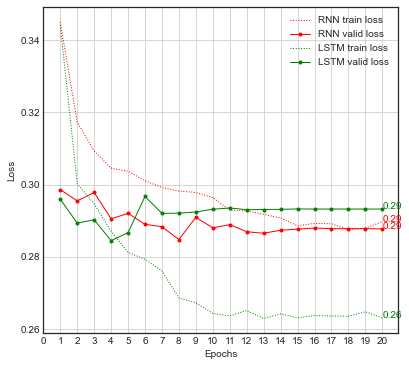

In [92]:
show_lcurve([history_rnn, history_lstm], ["RNN", "LSTM"], size=[14,6])

## GRU 순환 신경망

In [93]:
model = Sequential()
model.add(layers.Input(shape=(timestep, features)))
model.add(layers.GRU(32))
model.add(layers.Dense(1))
          
opt = optimizers.RMSprop(learning_rate=0.001)
          
model.compile(optimizer=opt, loss="mae")
          
history_gru = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=20,
                    steps_per_epoch=125,
                    validation_steps=val_steps,
                    callbacks=[lr])

Epoch 1/20
125/125 [==============================] - 9s 63ms/step - loss: 0.5018 - val_loss: 0.2941
Epoch 2/20
125/125 [==============================] - 8s 61ms/step - loss: 0.3125 - val_loss: 0.2871
Epoch 3/20
125/125 [==============================] - 8s 62ms/step - loss: 0.3051 - val_loss: 0.2830
Epoch 4/20
125/125 [==============================] - 8s 61ms/step - loss: 0.3012 - val_loss: 0.2821
Epoch 5/20
125/125 [==============================] - 7s 60ms/step - loss: 0.3010 - val_loss: 0.2788
Epoch 6/20
125/125 [==============================] - 8s 61ms/step - loss: 0.2939 - val_loss: 0.2825
Epoch 7/20
125/125 [==============================] - 8s 61ms/step - loss: 0.2921 - val_loss: 0.2777
Epoch 8/20
125/125 [==============================] - 8s 61ms/step - loss: 0.2879 - val_loss: 0.2821
Epoch 9/20
125/125 [==============================] - 7s 60ms/step - loss: 0.2901 - val_loss: 0.2777
Epoch 10/20
125/125 [==============================] - 8s 61ms/step - loss: 0.2864 - val_lo

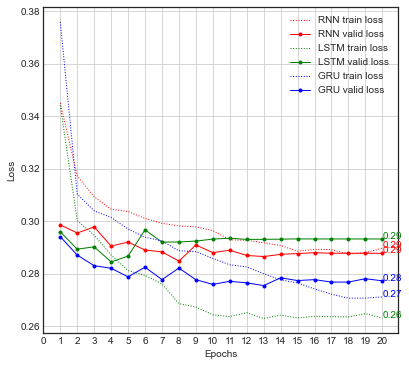

In [94]:
show_lcurve([history_rnn, history_lstm, history_gru], ["RNN", "LSTM","GRU"], size=[14,6])

## 순환 신경망 Stack

In [95]:
model = Sequential()
model.add(layers.Input(shape=(timestep, features)))
model.add(layers.GRU(32, return_sequences=True))
model.add(layers.GRU(32, return_sequences=True))
model.add(layers.GRU(32))
model.add(layers.Dense(1))

model.compile(optimizer=opt, loss="mae")

history_gru_stack = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=20,
                    steps_per_epoch=125,
                    validation_steps=val_steps,
                    callbacks=[lr])

Epoch 1/20
125/125 [==============================] - 16s 99ms/step - loss: 0.3939 - val_loss: 0.2919
Epoch 2/20
125/125 [==============================] - 12s 94ms/step - loss: 0.3149 - val_loss: 0.2861
Epoch 3/20
125/125 [==============================] - 11s 92ms/step - loss: 0.3038 - val_loss: 0.2816
Epoch 4/20
125/125 [==============================] - 11s 89ms/step - loss: 0.2971 - val_loss: 0.2846
Epoch 5/20
125/125 [==============================] - 12s 95ms/step - loss: 0.2899 - val_loss: 0.2786
Epoch 6/20
125/125 [==============================] - 12s 93ms/step - loss: 0.2858 - val_loss: 0.2776
Epoch 7/20
125/125 [==============================] - 11s 92ms/step - loss: 0.2827 - val_loss: 0.2836
Epoch 8/20
125/125 [==============================] - 12s 93ms/step - loss: 0.2759 - val_loss: 0.2767
Epoch 9/20
125/125 [==============================] - 11s 91ms/step - loss: 0.2719 - val_loss: 0.2810
Epoch 10/20
125/125 [==============================] - 11s 91ms/step - loss: 0.265

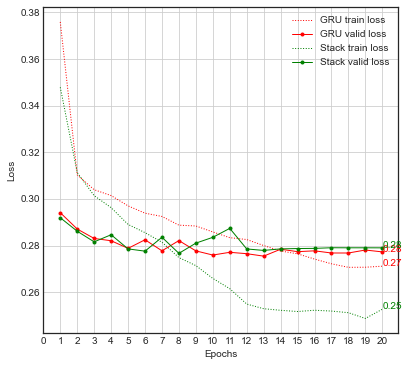

In [96]:
show_lcurve([history_gru, history_gru_stack], ["GRU", "Stack"], size=[14,6])

stack을 했을때 더 빠른속도로 과대적합이 일어나지만 정확도의 차이는 거의 없다

## Input 데이터를 뒤집었을때

In [98]:
train_gen_rev = generator(float_data,
                          lookback=lookback,
                          delay=delay,
                          min_index=0,
                          max_index=200000,
                          shuffle=True,
                          step=step,
                          batch_size=batch_size,
                          rev=True)
val_gen_rev = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=200001,
                        max_index=300000,
                        step=step,
                        batch_size=batch_size,
                        rev=True)

In [99]:
model = Sequential()
model.add(layers.Input(shape=(timestep, features)))
model.add(layers.GRU(32))
model.add(layers.Dense(1))

model.compile(optimizer=opt, loss="mae")

history_gru_rev = model.fit(train_gen_rev,
                    validation_data=val_gen_rev,
                    epochs=20,
                    steps_per_epoch=125,
                    validation_steps=val_steps,
                    callbacks=[lr])

Epoch 1/20
125/125 [==============================] - 10s 69ms/step - loss: 0.5312 - val_loss: 0.5170
Epoch 2/20
125/125 [==============================] - 8s 61ms/step - loss: 0.5016 - val_loss: 0.5042
Epoch 3/20
125/125 [==============================] - 7s 60ms/step - loss: 0.4780 - val_loss: 0.4983
Epoch 4/20
125/125 [==============================] - 8s 61ms/step - loss: 0.4560 - val_loss: 0.4923
Epoch 5/20
125/125 [==============================] - 7s 60ms/step - loss: 0.4222 - val_loss: 0.4725
Epoch 6/20
125/125 [==============================] - 8s 60ms/step - loss: 0.4004 - val_loss: 0.4478
Epoch 7/20
125/125 [==============================] - 8s 61ms/step - loss: 0.3836 - val_loss: 0.4276
Epoch 8/20
125/125 [==============================] - 8s 62ms/step - loss: 0.3667 - val_loss: 0.4156
Epoch 9/20
125/125 [==============================] - 7s 60ms/step - loss: 0.3551 - val_loss: 0.4136
Epoch 10/20
125/125 [==============================] - 8s 60ms/step - loss: 0.3463 - val_l

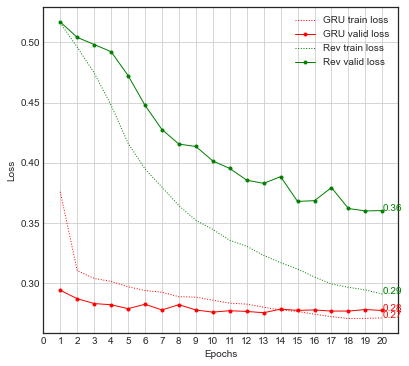

In [100]:
show_lcurve([history_gru, history_gru_rev], ["GRU", "Rev"], size=[14,6])

* 순환 신경망에서 데이터를 뒤집는 다는 것은 가장 처음나온 데이터가 중요하다는 뜻이다. 
    - 하지만 온도 예측에서는 가장 마지막 데이터가 중요하기 때문에 뒤집었을때 성능이 굉장히 떨어지게 된다

## 양방향 순환신경망

In [101]:
model = Sequential()
model.add(layers.Input(shape=(timestep, features)))
model.add( layers.Bidirectional(layers.GRU(32)) )
model.add(layers.Dense(1))
          
opt = optimizers.RMSprop(learning_rate=0.001)
          
model.compile(optimizer=opt, loss="mae")
          
history_gru_bi = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=20,
                    steps_per_epoch=125,
                    validation_steps=val_steps,
                    callbacks=[lr])

Epoch 1/20
125/125 [==============================] - 11s 71ms/step - loss: 0.3983 - val_loss: 0.2860
Epoch 2/20
125/125 [==============================] - 8s 66ms/step - loss: 0.3034 - val_loss: 0.2867
Epoch 3/20
125/125 [==============================] - 8s 64ms/step - loss: 0.2970 - val_loss: 0.2817
Epoch 4/20
125/125 [==============================] - 8s 67ms/step - loss: 0.2928 - val_loss: 0.2831
Epoch 5/20
125/125 [==============================] - 8s 67ms/step - loss: 0.2893 - val_loss: 0.2759
Epoch 6/20
125/125 [==============================] - 9s 68ms/step - loss: 0.2870 - val_loss: 0.2775
Epoch 7/20
125/125 [==============================] - 8s 67ms/step - loss: 0.2818 - val_loss: 0.3047
Epoch 8/20
125/125 [==============================] - 9s 68ms/step - loss: 0.2816 - val_loss: 0.2756
Epoch 9/20
125/125 [==============================] - 8s 68ms/step - loss: 0.2792 - val_loss: 0.2834
Epoch 10/20
125/125 [==============================] - 9s 70ms/step - loss: 0.2786 - val_l

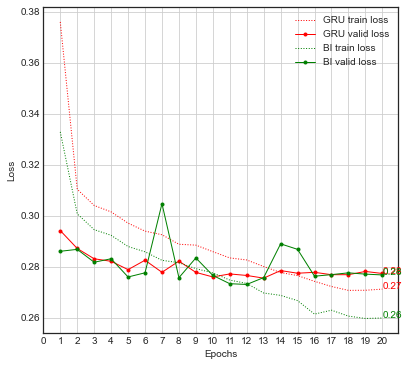

In [103]:
show_lcurve([history_gru, history_gru_bi], ["GRU", "BI"], size=[14,6])

* 양방향의 경우 과대적합이 조금더 빠르게 일어나고있으며 특정epochs 에서 loss가 크게 뛰는 구간이 있다.
* 하지만 성능의 차이는 미미하다

## Dropout 층을 사용한 Stack, 양방향 (가장 두텁게)

In [110]:
model = Sequential()
model.add(layers.Input(shape=(timestep, features)))
model.add( layers.Bidirectional(layers.GRU(32, return_sequences=True, dropout=0.2)) )
model.add( layers.Bidirectional(layers.GRU(32, return_sequences=True, dropout=0.2)) )
model.add( layers.Bidirectional(layers.GRU(32, dropout=0.2)) )
model.add(layers.Dense(1))

opt = optimizers.RMSprop(learning_rate=0.1)
lr = callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
model.compile(optimizer=opt, loss="mae")

history_gru_BN = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=50,
                    steps_per_epoch=125,
                    validation_steps=val_steps,
                    callbacks=[lr])

Epoch 1/50
125/125 [==============================] - 34s 212ms/step - loss: 2.0331 - val_loss: 0.6263
Epoch 2/50
125/125 [==============================] - 22s 174ms/step - loss: 0.6019 - val_loss: 0.4467
Epoch 3/50
125/125 [==============================] - 22s 179ms/step - loss: 0.5135 - val_loss: 0.6822
Epoch 4/50
125/125 [==============================] - 21s 172ms/step - loss: 0.5185 - val_loss: 0.4904
Epoch 5/50
125/125 [==============================] - 21s 169ms/step - loss: 0.4813 - val_loss: 0.4113
Epoch 6/50
125/125 [==============================] - 23s 181ms/step - loss: 0.4638 - val_loss: 0.4210
Epoch 7/50
125/125 [==============================] - 23s 182ms/step - loss: 0.4648 - val_loss: 0.4072
Epoch 8/50
125/125 [==============================] - 22s 175ms/step - loss: 0.4548 - val_loss: 0.4100
Epoch 9/50
125/125 [==============================] - 22s 179ms/step - loss: 0.4486 - val_loss: 0.3884
Epoch 10/50
125/125 [==============================] - 23s 184ms/step - l

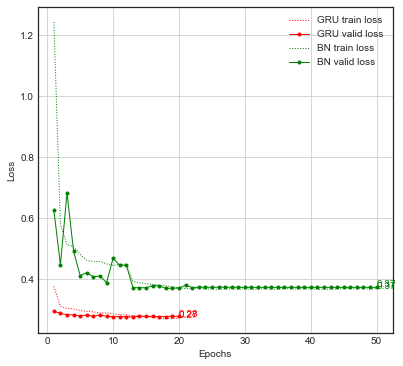

In [120]:
show_lcurve([history_gru, history_gru_BN], ["GRU", "BN"], size=[14,6], x_itv=10)

## 순환신경망 층 앞 Dense 층

In [116]:
model = Sequential()
model.add(layers.Input(shape=(timestep, features)))
model.add(layers.Dense(30, activation="relu"))
model.add(layers.GRU(32))
model.add(layers.Dense(1))

opt = optimizers.RMSprop(learning_rate=0.01)
lr = callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

model.compile(optimizer=opt, loss="mae")
history_Dense = model.fit(train_gen,
                          validation_data=val_gen,
                          epochs=20,
                          steps_per_epoch=125,
                          validation_steps=val_steps,
                          callbacks=[lr])

Epoch 1/20
125/125 [==============================] - 10s 65ms/step - loss: 0.4254 - val_loss: 0.3067
Epoch 2/20
125/125 [==============================] - 8s 64ms/step - loss: 0.3217 - val_loss: 0.2930
Epoch 3/20
125/125 [==============================] - 8s 63ms/step - loss: 0.3040 - val_loss: 0.2947
Epoch 4/20
125/125 [==============================] - 8s 63ms/step - loss: 0.2866 - val_loss: 0.2865
Epoch 5/20
125/125 [==============================] - 8s 62ms/step - loss: 0.2702 - val_loss: 0.2973
Epoch 6/20
125/125 [==============================] - 8s 62ms/step - loss: 0.2540 - val_loss: 0.3118
Epoch 7/20
125/125 [==============================] - 8s 63ms/step - loss: 0.2396 - val_loss: 0.3180
Epoch 8/20
125/125 [==============================] - 8s 63ms/step - loss: 0.2312 - val_loss: 0.3170
Epoch 9/20
125/125 [==============================] - 8s 61ms/step - loss: 0.2230 - val_loss: 0.3188
Epoch 10/20
125/125 [==============================] - 8s 62ms/step - loss: 0.1934 - val_l

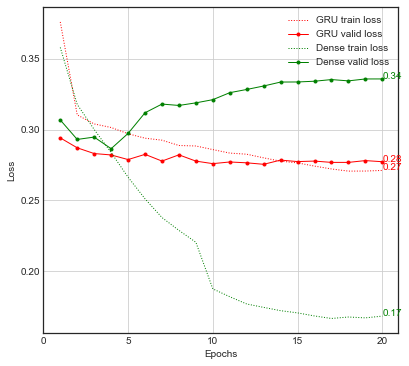

In [122]:
show_lcurve([history_gru, history_Dense], ["GRU", "Dense"], size=[14,6], x_itv=5)

## ps

In [16]:
timestep = 240
features = 14

model = Sequential()
model.add(layers.Input(shape=(timestep, features)))
model.add(layers.SimpleRNN(32, return_sequences=True))
model.add(layers.SimpleRNN(32, return_sequences=True))
model.add(layers.SimpleRNN(32))
model.add(layers.Dense(1))

optimizer = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mae")
history_rnn_BN = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=40,
                    steps_per_epoch=125,
                    validation_steps=val_steps)

Epoch 1/40
125/125 [==============================] - 61s 471ms/step - loss: 0.2924 - val_loss: 0.2970
Epoch 2/40
125/125 [==============================] - 57s 460ms/step - loss: 0.2846 - val_loss: 0.2950
Epoch 3/40
125/125 [==============================] - 62s 494ms/step - loss: 0.2816 - val_loss: 0.3023
Epoch 4/40
125/125 [==============================] - 57s 458ms/step - loss: 0.2811 - val_loss: 0.3153
Epoch 5/40
125/125 [==============================] - 59s 471ms/step - loss: 0.2798 - val_loss: 0.2989
Epoch 6/40
125/125 [==============================] - 59s 469ms/step - loss: 0.2767 - val_loss: 0.3117
Epoch 7/40
125/125 [==============================] - 61s 490ms/step - loss: 0.2745 - val_loss: 0.3042
Epoch 8/40
125/125 [==============================] - 65s 518ms/step - loss: 0.2734 - val_loss: 0.3052
Epoch 9/40
125/125 [==============================] - 62s 497ms/step - loss: 0.2701 - val_loss: 0.3061
Epoch 10/40
125/125 [==============================] - 71s 565ms/step - l

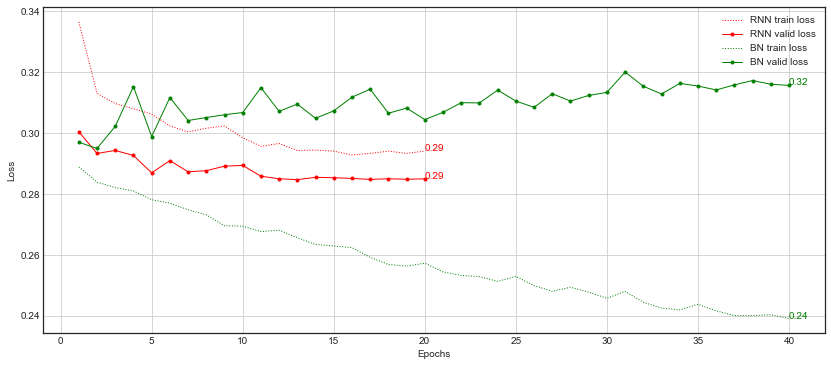

In [19]:
show_lcurve([history_rnn, history_rnn_BN], ["RNN", "BN"], size=[14,6], x_itv=5)

In [21]:
timestep = 240
features = 14

model = Sequential()
model.add(layers.Input(shape=(timestep, features)))
model.add(layers.SimpleRNN(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(layers.SimpleRNN(32, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(1))

optimizer = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mae")

with tf.device("CPU:0"):
    history_rnn_dropout = model.fit(train_gen,
                        validation_data=val_gen,
                        epochs=20,
                        steps_per_epoch=125,
                        validation_steps=val_steps)

Epoch 1/20
125/125 [==============================] - 37s 283ms/step - loss: 0.5860 - val_loss: 0.3287
Epoch 2/20
125/125 [==============================] - 35s 284ms/step - loss: 0.4026 - val_loss: 0.3276
Epoch 3/20
125/125 [==============================] - 35s 283ms/step - loss: 0.3800 - val_loss: 0.3061
Epoch 4/20
125/125 [==============================] - 35s 284ms/step - loss: 0.3707 - val_loss: 0.3001
Epoch 5/20
125/125 [==============================] - 35s 283ms/step - loss: 0.3671 - val_loss: 0.3021
Epoch 6/20
125/125 [==============================] - 35s 279ms/step - loss: 0.3613 - val_loss: 0.3040
Epoch 7/20
125/125 [==============================] - 35s 278ms/step - loss: 0.3538 - val_loss: 0.3043
Epoch 8/20
125/125 [==============================] - 35s 279ms/step - loss: 0.3523 - val_loss: 0.3024
Epoch 9/20
125/125 [==============================] - 35s 280ms/step - loss: 0.3519 - val_loss: 0.3002
Epoch 10/20
125/125 [==============================] - 35s 280ms/step - l

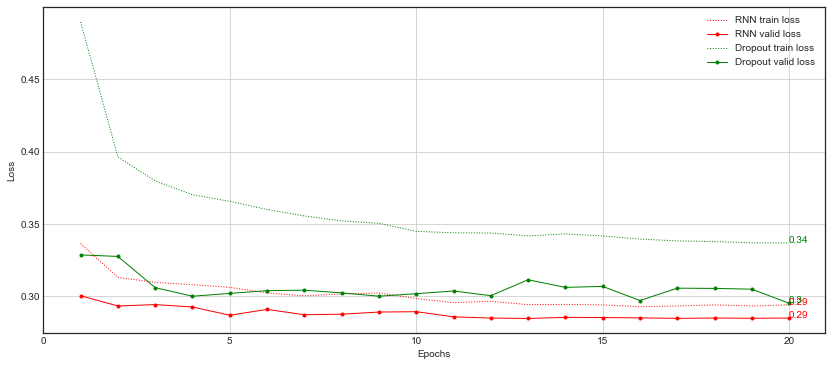

In [22]:
show_lcurve([history_rnn, history_rnn_dropout], ["RNN", "Dropout"], size=[14,6], x_itv=5)

# 정리

* 상식 수준의 기준점을 설정, 기준점이 있어야 모델의 성능을 가늠할 수 있음
* 시간 순서가 의미가 있다면 순환신경망 층이 더 좋음
* 순환신경망의 드롭아웃에는 dropout, recurrent_dropout 가 있음
    - dropout 은 입력데이터에 대한것이고
    - recurrent_dropout 는 순환 데이터에 대한 것이다.
    - 하지만 return_seequences !=0 이면 GPU를 사용할 수 없다.
* 단일 layer 보다 Stacked layer가 더 강력한 표현을 하지만 비용이 많이 들기 때문에 크게 시도할 가치가 없다
* 양방향 layer는 자연어 처리에 유용하고 직선적인 시간에 대한 정보에는 유리하지 않다